In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Binning summary

In [226]:
#Specify the file 
file_name = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307210204 nas\Binning summary\LogReg_GiveMeSomeCredit_nas.xlsx'
remove_missings = False

In [227]:
#Read all sheets
dfs = pd.read_excel(file_name, sheet_name = None)

In [228]:
#Adjust the tables
new_dfs = {}
for sheet in dfs: #Loop through all variables
    df = dfs[sheet] #Get the info for a given variable
    cols_to_drop = ['Unnamed: 0', 'JS'] #Specify the columns to drop
    for i in cols_to_drop: #Drop obsolete columns
        df.drop(i, axis = 1, inplace = True) 
    df.loc[df['Bin'].isna(), 'Bin'] = 'Totals' #Adjust the bin column so it can be used as index
    df.set_index('Bin', inplace = True) #Set the bins as indices
    df.drop('Special', axis = 0, inplace = True) #Drop the empty special bin
    if remove_missings: #Drop the bin for missings if required
        df.drop('Missing', axis = 0, inplace = True)
    for i in ['Count (%)', 'Event rate']: #Convert two columns to percentages
        df[i] = df[i] * 100
    df = df.round(2) #Round numerical columns for clarity
    df.rename(columns = {'Event rate' : 'ER'}, inplace = True) #Rename columns for clarity
    new_dfs[sheet] = df #Store the adjusted data set

In [229]:
#Get IVs for all variables
IVs = {}
for sheet in new_dfs:
    IVs[sheet] = new_dfs[sheet].loc['Totals', 'IV'] #Extract IV for a given variable
IVs = pd.Series(IVs).sort_values(ascending = False) #Sort from best to worst

In [230]:
#Adjust variable names
IVs.rename({'RevolvingUtilizationOfUnsecured' : 'RevUtilization', 'NumberOfTime30-59DaysPastDueNot' : 'NoOfTimePD',
             'NumberOfOpenCreditLinesAndLoans' : 'NoOfLoans', 'NumberRealEstateLoansOrLines' : 'NoOfMortgs', 'NumberOfDependents' :'NoOfDeps'}, inplace = True)

Text(0, 0.5, 'IV')

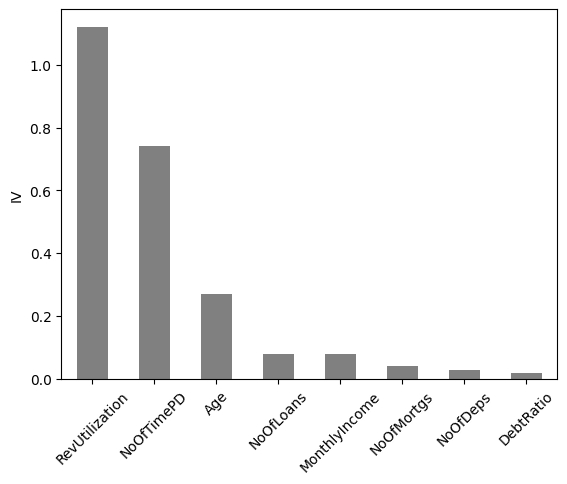

In [232]:
#Plot IVs
IVs.plot.bar(color = 'grey')
plt.xticks(rotation = 45)
plt.ylabel('IV')
#plt.savefig('Run 202307170821 main/IVs.pdf', bbox_inches = 'tight')

In [235]:
#Export given variable to latex
var = 'MonthlyIncome'
new_dfs[var].to_latex(f'Run 202307210204 nas/{var}.txt', index = True, na_rep = '', position = '!htbp', caption = f'Binning of {var}', label = f'tab:{var[:3].lower()}')

C:\Users\matya\AppData\Local\Temp\ipykernel_7552\1763262388.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  new_dfs[var].to_latex(f'Run 202307210204 nas/{var}.txt', index = True, na_rep = '', position = '!htbp', caption = f'Binning of {var}', label = f'tab:{var[:3].lower()}')


# Model coefficients

In [33]:
model_file = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307170821 main\Models\LogReg_HomeCredit_binned_main.pkl'
with open(model_file, 'rb') as handle:
    model = pickle.load(handle)

In [40]:
import numpy as np
sum(np.array(list(model['model'].intercept_) + list(model['model'].coef_[0])) == 0)

7

In [ ]:
model_coefs = pd.Series(list(model['model'].intercept_) + list(model['model'].coef_[0]), index = ['Intercept'] + model['binning'].transformers_[0][1]['binning'].variable_names)

In [32]:
model_coefs.to_latex(f'D:\My stuff\School\Master\Master Thesis\Project\Run 202307170821 main\Model coefficients LogReg_GMSC_binned_main.txt', index = True, na_rep = '', position = '!htbp', caption = f'Model coefficients for LogReg GMSC (binned)', label = f'tab:logcoef')

C:\Users\matya\AppData\Local\Temp\ipykernel_5784\2652368389.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  model_coefs.to_latex(f'D:\My stuff\School\Master\Master Thesis\Project\Run 202307170821 main\Model coefficients LogReg_GMSC_binned_main.txt', index = True, na_rep = '', position = '!htbp', caption = f'Model coefficients for LogReg GMSC (binned)', label = f'tab:logcoef')


# Add averages to metric results

In [23]:
#Specify the file name
file_name_res = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307170821 main\Evaluation\main.xlsx'

In [24]:
#Load the file
df_res = pd.read_excel(file_name_res, sheet_name = None, index_col = 0)

In [25]:
#Adjust the results
metric_names = df_res['Metrics'].columns.to_list()
df_res['Metrics']['Method'] = [i.split('_')[0] for i in df_res['Metrics'].index]
df_res['Metrics']['Data set'] = [i.split('_')[1] for i in df_res['Metrics'].index]
df_res['Metrics']['Type'] = [i.split('_')[2] for i in df_res['Metrics'].index]
df_res['Metrics'] = df_res['Metrics'].loc[:, ['Method', 'Data set', 'Type'] + metric_names] #Move indicator columns in the beginning
df_res['Metrics'].sort_values(['Method', 'Data set', 'Type'], inplace = True)
#Separate the results by models and export to latex
dfs = {}
for model_name in df_res['Metrics']['Method'].unique(): #Loop through all models
    df = df_res['Metrics'].loc[df_res['Metrics']['Method'] == model_name, :].copy() #Subset the original data set
    df.drop('Method', axis = 1, inplace = True) #Drop the obsolete model column
    df.reset_index(drop = True, inplace = True) #Disregard the index
    binned_avg = df.loc[df['Type'] == 'binned', metric_names].mean().to_list()
    raw_avg = df.loc[df['Type'] == 'raw', metric_names].mean().to_list()
    df.loc[df.shape[0], :] = ['binned > raw', '-'] + (df.loc[df['Type'] == 'binned', metric_names].reset_index(drop = True) > df.loc[df['Type'] == 'raw', metric_names].reset_index(drop = True)).sum().to_list()
    df.loc[df.shape[0] - 1, 'Brier score'] = (df.loc[df['Type'] == 'binned', 'Brier score'].reset_index(drop = True) < df.loc[df['Type'] == 'raw', 'Brier score'].reset_index(drop = True)).sum() #Adjust Brier score since the lower the better
    df.loc[df.shape[0], :] = ['Average', 'binned'] + binned_avg
    df.loc[df.shape[0], :] = ['Average', 'raw'] + raw_avg
    dfs[model_name] = df

In [26]:
#Adjust the permtests
metric_names = df_res['Permutation test'].columns.to_list()
df_res['Permutation test']['Method'] = [i.split('_')[0] for i in df_res['Permutation test'].index]
df_res['Permutation test']['Data set'] = [i.split('_')[1] for i in df_res['Permutation test'].index]
df_res['Permutation test'] = df_res['Permutation test'].loc[:, ['Method', 'Data set'] + metric_names] #Move indicator columns in the beginning
df_res['Permutation test'].sort_values(['Method', 'Data set'], inplace = True)
#Separate the results by models and export to latex
dfs_perm = {}
for model_name in df_res['Permutation test']['Method'].unique(): #Loop through all models
    df = df_res['Permutation test'].loc[df_res['Permutation test']['Method'] == model_name, :].copy() #Subset the original data set
    df.drop('Method', axis = 1, inplace = True) #Drop the obsolete model column
    df.reset_index(drop = True, inplace = True) #Disregard the index
    df.loc[df.shape[0], :] = ['p <= 0.05'] + (df.loc[:, metric_names] <= 0.05).sum().to_list()
    dfs_perm[model_name] = df

In [61]:
dfs['GaussNB']

,Data set,Type,AUC,F2-score,Brier score,KS statistic,Partial GINI Index,H-measure
0,CreditApproval,binned,0.886310,0.819892,0.138943,0.683333,0.713178,0.578628
1,CreditApproval,raw,0.855000,0.819892,0.172279,0.670476,0.237500,0.523168
2,CreditCardTaiwan,binned,0.759620,0.520200,0.187222,0.405745,0.237041,0.259751
3,CreditCardTaiwan,raw,0.670445,0.394897,0.416962,0.263441,0.148461,0.118907
4,GiveMeSomeCredit,binned,0.805468,0.327702,0.088479,0.486348,0.458243,0.305578
5,GiveMeSomeCredit,raw,0.691049,0.218668,0.066822,0.270625,0.352845,0.126812
6,HomeCredit,binned,0.688464,0.199770,0.890726,0.289343,0.129610,0.115313
7,HomeCredit,raw,0.605359,0.134747,0.072548,0.159099,0.210744,0.035671
8,SouthGermanCredit,binned,0.634818,0.441640,0.218104,0.225339,0.094422,0.117168
9,SouthGermanCredit,raw,0.629500,0.453074,0.218014,0.230248,0.152652,0.103634


In [62]:
dfs_perm['GaussNB']

,Data set,AUC,F2-score,Brier score,KS statistic,Partial GINI Index,H-measure
0,CreditApproval,0.0472,0.5886,0.0922,0.2038,0.0344,0.1398
1,CreditCardTaiwan,0.0000,0.0000,0.0000,0.0000,0.1004,0.0000
2,GiveMeSomeCredit,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,HomeCredit,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
4,SouthGermanCredit,0.3270,0.3704,0.5032,0.4712,0.7268,0.3208
5,p <= 0.05,4.0000,3.0000,1.0000,3.0000,2.0000,3.0000


# Get evaluation plot

In [2]:
#Specify file names
model_file_binned = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307170821 main\Models\LogReg_HomeCredit_binned_main.pkl'
model_file_raw = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307170821 main\Models\LogReg_HomeCredit_raw_main.pkl'

In [3]:
#Load the models
with open(model_file_binned, 'rb') as handle:
    model_binned = pickle.load(handle)
with open(model_file_raw, 'rb') as handle:
    model_raw = pickle.load(handle)

In [4]:
#Load the test set
df_test = pd.read_csv('D:\My stuff\School\Master\Master Thesis\Data\Test data\HomeCredit_main.csv')

In [5]:
#Get predictions
indep_vars = df_test.columns.to_list()
indep_vars.remove('Target') #Drop the dependent variable form the list
preds_binned = model_binned.predict_proba(df_test.loc[:, indep_vars])[:, 1]
preds_raw = model_raw.predict_proba(df_test.loc[:, indep_vars])[:, 1]

In [8]:
#Evaluate
from sklearn.metrics import roc_auc_score
generator = np.random.RandomState(69) #Initiate a generator
ids = generator.choice(2, (5000, preds_binned.shape[0]), replace = True) #Generate ids for all repetitions
preds = np.stack([preds_binned, preds_raw], axis = 1)[range(preds_binned.shape[0]), ids] #Put the predictions into a single array
res = np.apply_along_axis(lambda x: roc_auc_score(df_test['Target'], x), 1, preds) #Apply the function to each column
res = pd.DataFrame(list(res)) #Create a Data Frame from the results
res1 = roc_auc_score(df_test['Target'], preds_binned) #Get the performance of the model in question

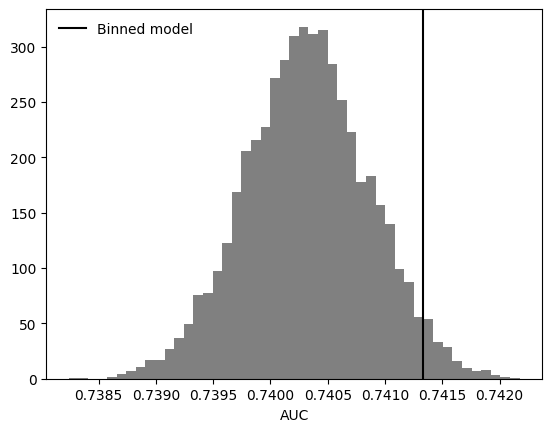

In [22]:
#Plot
plt.hist(res, 'auto', color = 'grey') #Plot a histogram
plt.xlabel('AUC') #Add a label for the x axis
plt.axvline(res1, color = 'black', label = 'Binned model') #Add a vertical line with the result of the model in question
plt.legend(loc = 'upper left', frameon = False) #Add a legend
plt.savefig('Run 202307170821 main/perm_test.pdf', bbox_inches = 'tight') #Save the plot

# Get tree structure

In [2]:
#Specify the file names
tree_binned_file_name = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307202046 main\Models\DecTree_GiveMeSomeCredit_binned_main.pkl'
tree_raw_file_name = 'D:\My stuff\School\Master\Master Thesis\Project\Run 202307202046 main\Models\DecTree_GiveMeSomeCredit_raw_main.pkl'
data_file_name = 'D:\My stuff\School\Master\Master Thesis\Data\Train data\GiveMeSomeCredit_main.csv'

In [3]:
#Load the models
with open(tree_binned_file_name, 'rb') as handle:
    tree_binned = pickle.load(handle)
with open(tree_raw_file_name, 'rb') as handle:
    tree_raw = pickle.load(handle)

In [4]:
#Load data and get feature names
df = pd.read_csv(data_file_name)
feature_names = df.columns.to_list()

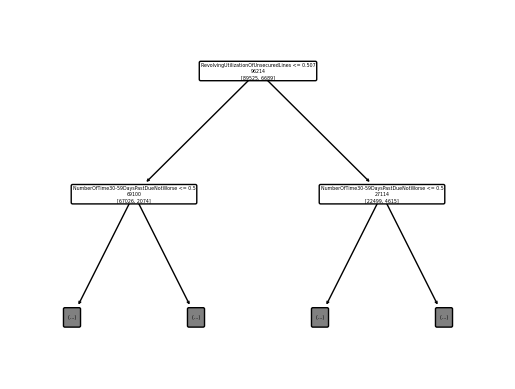

In [5]:
#Plot the raw tree
from sklearn.tree import plot_tree
tree_raw_plot = plot_tree(tree_raw, feature_names = feature_names, label = 'None', impurity = False, rounded = True, max_depth = 1)
plt.savefig('Run 202307202046 main/tree_raw_GMSC.pdf', bbox_inches = 'tight')

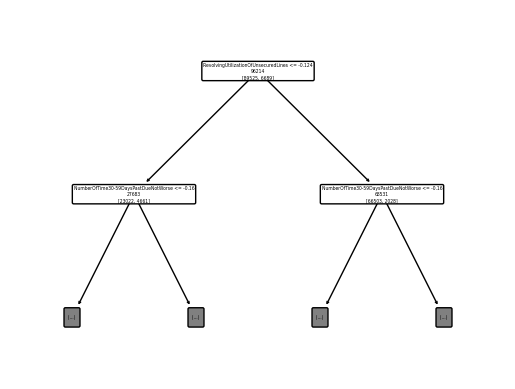

In [6]:
#Plot the binned tree
tree_binned_plot = plot_tree(tree_binned['model'], feature_names = feature_names, label = 'None', impurity = False, rounded = True, max_depth = 1)
plt.savefig('Run 202307202046 main/tree_binned_GMSC.pdf', bbox_inches = 'tight')

# Summarize results

In [2]:
#Specify the file name
file_name_res = 'D:/My stuff/School/Master/Master Thesis/Project/Run 202307262207 no_outs/Evaluation/no_outs.xlsx'

In [3]:
#Load the file
df_res = pd.read_excel(file_name_res, sheet_name = None, index_col = 0)

In [205]:
#Drop averages calculated in Excel
#df_res['Metrics'] = df_res['Metrics'].loc[[i for i in df_res['Metrics'].index if i not in ['Avg_binned', 'Avg_raw']], :]
#df_res['Permutation test'] = df_res['Permutation test'].loc[[i for i in df_res['Permutation test'].index if i != 'p <= 0.05'], :]

In [4]:
#Adjust the results
metric_names = df_res['Metrics'].columns.to_list()
df_res['Metrics']['Method'] = [i.split('_')[0] for i in df_res['Metrics'].index]
df_res['Metrics']['Data set'] = [i.split('_')[1] for i in df_res['Metrics'].index]
df_res['Metrics']['Type'] = [i.split('_')[2] for i in df_res['Metrics'].index]
df_res['Metrics'] = df_res['Metrics'].loc[:, ['Method', 'Data set', 'Type'] + metric_names] #Move indicator columns in the beginning
df_res['Metrics']['Method'] = pd.Categorical(df_res['Metrics']['Method'], ['LogReg', 'DecTree', 'RandForest', 'NN', 'GaussNB']) #Specify the categories for ordering
df_res['Metrics'].sort_values(['Method', 'Data set', 'Type'], inplace = True)
df_res['Metrics'].reset_index(drop = True, inplace = True)
df_res['Metrics']['Data set'] = df_res['Metrics']['Data set'].replace({'CreditApproval' : 'CA', 'GiveMeSomeCredit' : 'GMSC', 'HomeCredit' : 'HCDR', 'CreditCardTaiwan' : 'DCCCT', 'SouthGermanCredit' : 'SGCC'})

In [5]:
#Calculate averages
avgs = df_res['Metrics'].groupby(['Method', 'Type'])[metric_names].mean().reset_index(drop = False) #Calculate the averages
avgs['Data set'] = 'Average' #Indicate that the rows represent averages
avgs = avgs.loc[:, ['Method', 'Data set', 'Type'] + metric_names] #Reorder columns for clarity

In [6]:
#Calculate total averages
total_avgs = df_res['Metrics'].loc[df_res['Metrics']['Data set'] != 'Average', :].groupby('Type')[metric_names].mean() #Calculate total averages across all methods and data sets
total_avgs.reset_index(drop = False, inplace = True)
total_avgs['Method'] = 'All'
total_avgs['Data set'] = 'Average'
total_avgs = total_avgs.loc[:, ['Method', 'Data set', 'Type'] + metric_names] #Reorder for clarity

In [7]:
#Calculate the number of times binned model is better
counts = df_res['Metrics'].loc[df_res['Metrics']['Type'] == 'binned', metric_names].reset_index(drop = True) > df_res['Metrics'].loc[df_res['Metrics']['Type'] == 'raw', metric_names].reset_index(drop = True) #Indicate for each cell if binned is larger or not
counts['Brier score'] = df_res['Metrics'].loc[df_res['Metrics']['Type'] == 'binned', 'Brier score'].values < df_res['Metrics'].loc[df_res['Metrics']['Type'] == 'raw', 'Brier score'].values
counts['Method'] = df_res['Metrics'].loc[df_res['Metrics']['Type'] == 'binned', 'Method'].reset_index(drop = True) #Add method names
counts = counts.groupby('Method').sum().reset_index(drop = False) #Sum occurrences for each method
counts['Data set'] = 'binned > raw' #Add indicator
counts['Type'] = '-' #Add type indicator
counts = counts.loc[:, ['Method', 'Data set', 'Type'] + metric_names] #Reorder columns for clarity

In [8]:
#Calculate total counts
total_counts = counts[metric_names].sum()
total_counts['Method'] = 'All'
total_counts['Data set'] = 'binned > raw'
total_counts['Type'] = '-'
total_counts = total_counts.loc[['Method', 'Data set', 'Type'] + metric_names]

In [9]:
#Define a function wrapping a value in latex bold command
def make_bold(x):
    '''
    Function wrapping a value in latex bold command
    '''
    return f'\textbf{{{x}}}'

In [10]:
#Add averages to the data set and make a copy for export to latex
df_res['Metrics'] = pd.concat([df_res['Metrics'], avgs, total_avgs], ignore_index = True) #Add averages
df_metrics_latex = df_res['Metrics'].copy() #Make a copy of the data set for export to latex
df_metrics_latex.loc[:, metric_names] = round(df_metrics_latex.loc[:, metric_names], 3).astype(str) #Round to the third decimal and convert to text

In [11]:
#Add latex bold command indicating better performance of given model type
for idx in range(0, df_res['Metrics'].shape[0], 2): #Loop through all model/data set combinations
    for col in metric_names: #Loop through all columns
        if df_res['Metrics'].loc[idx, col] > df_res['Metrics'].loc[idx + 1, col]: #Check if binned is larger
            if col == 'Brier score': #The lower BS the better => different treatment
                df_metrics_latex.loc[idx + 1, col] = make_bold(df_metrics_latex.loc[idx + 1, col])
            else:
                df_metrics_latex.loc[idx, col] = make_bold(df_metrics_latex.loc[idx, col])
        elif df_res['Metrics'].loc[idx, col] < df_res['Metrics'].loc[idx + 1, col]: #Check if binned is smaller
            if col == 'Brier score': #The lower BS the better => different treatment
                df_metrics_latex.loc[idx, col] = make_bold(df_metrics_latex.loc[idx, col])
            else:
                df_metrics_latex.loc[idx + 1, col] = make_bold(df_metrics_latex.loc[idx + 1, col])

In [12]:
#Add counts and sort the final data set
df_metrics_latex = pd.concat([df_metrics_latex, counts], ignore_index = True) #Add counts
df_metrics_latex.loc[df_metrics_latex.shape[0], :] = total_counts #Add total counts
df_metrics_latex['Method'] = pd.Categorical(df_metrics_latex['Method'], ['LogReg', 'DecTree', 'RandForest', 'NN', 'GaussNB', 'All']) #Specify the categories for ordering
df_metrics_latex['Data set'] = pd.Categorical(df_metrics_latex['Data set'], ['CA', 'DCCCT', 'GMSC', 'HCDR', 'SGCC', 'binned > raw', 'Average'])
df_metrics_latex.sort_values(['Method', 'Data set', 'Type'], inplace = True, ignore_index = True)

In [20]:
#Export to latex
df_metrics_latex.to_latex('Run 202307262207 no_outs/complete_results_latex.txt', index = False, na_rep = '', caption = 'Complete results - estimation without outliers', label = 'tab:nooutscompres', position = '!htbp', escape = False)

C:\Users\matya\AppData\Local\Temp\ipykernel_14252\1195189442.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_metrics_latex.to_latex('Run 202307262207 no_outs/complete_results_latex.txt', index = False, na_rep = '', caption = 'Complete results - estimation without outliers', label = 'tab:nooutscompres', position = '!htbp', escape = False)


In [15]:
#Adjust permutation tests
df_res['Permutation test']['Method'] = [i.split('_')[0] for i in df_res['Permutation test'].index]
df_res['Permutation test']['Data set'] = [i.split('_')[1] for i in df_res['Permutation test'].index]
df_res['Permutation test'] = df_res['Permutation test'].loc[:, ['Method', 'Data set'] + metric_names] #Move indicator columns in the beginning
df_res['Permutation test']['Method'] = pd.Categorical(df_res['Permutation test']['Method'], ['LogReg', 'DecTree', 'RandForest', 'NN', 'GaussNB']) #Specify the categories for ordering
df_res['Permutation test'].sort_values(['Method', 'Data set'], inplace = True)
df_res['Permutation test'].reset_index(drop = True, inplace = True)
df_res['Permutation test']['Data set'] = df_res['Permutation test']['Data set'].replace({'CreditApproval' : 'CA', 'GiveMeSomeCredit' : 'GMSC', 'HomeCredit' : 'HCDR', 'CreditCardTaiwan' : 'DCCCT', 'SouthGermanCredit' : 'SGCC'})

In [16]:
#Calculate counts of rejection of the null hypothesis
perm_counts = df_res['Permutation test'].loc[:, metric_names] <= 0.05
perm_counts['Method'] = df_res['Permutation test']['Method']
perm_counts = perm_counts.groupby('Method')[metric_names].sum()
perm_counts.reset_index(drop = False, inplace = True)
perm_counts['Data set'] = 'p <= 0.05'
perm_counts['Type'] = '-'
perm_counts = perm_counts.loc[:, ['Method', 'Data set', 'Type'] + metric_names]

In [17]:
#Prepare permutation tests for export
perm_tests_latex = df_res['Permutation test'].copy() #pd.concat([df_res['Permutation test'], perm_counts], ignore_index = True)
perm_tests_latex = perm_tests_latex.round(3)
for col in metric_names:
    for idx in range(perm_tests_latex.shape[0]):
        if df_res['Permutation test'].loc[idx, col] <= 0.05:
            perm_tests_latex.loc[idx, col] = make_bold(perm_tests_latex.loc[idx, col])
perm_tests_latex = pd.concat([perm_tests_latex, perm_counts.drop('Type', axis = 1)], ignore_index = True)
perm_tests_latex['Method'] = pd.Categorical(perm_tests_latex['Method'], ['LogReg', 'DecTree', 'RandForest', 'NN', 'GaussNB'])
perm_tests_latex['Data set'] = pd.Categorical(perm_tests_latex['Data set'], ['CA', 'GMSC', 'DCCCT', 'HCDR', 'SGCC', 'p <= 0.05'])
perm_tests_latex.sort_values(['Method', 'Data set'], inplace = True, ignore_index = True)

In [18]:
#Export permutation tests
perm_tests_latex.to_latex('Run 202307262207 no_outs/complete_permutation_tests_latex.txt', index = False, na_rep = '', caption = 'Permutation tests - estimation without outliers', label = 'tab:nooutsperm', position = '!htbp', escape = False)

C:\Users\matya\AppData\Local\Temp\ipykernel_14252\1909926118.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  perm_tests_latex.to_latex('Run 202307262207 no_outs/complete_permutation_tests_latex.txt', index = False, na_rep = '', caption = 'Permutation tests - estimation without outliers', label = 'tab:nooutsperm', position = '!htbp', escape = False)


In [19]:
#Create a summary of the results
res_sum = pd.concat([df_metrics_latex.loc[df_metrics_latex['Data set'].isin(['Average', 'binned > raw']) & np.invert(df_metrics_latex['Method'] == 'All'), :], perm_counts], ignore_index = True)
res_sum['Method'] = pd.Categorical(res_sum['Method'], ['LogReg', 'DecTree', 'RandForest', 'NN', 'GaussNB'])
res_sum['Data set'] = pd.Categorical(res_sum['Data set'], ['binned > raw', 'Average', 'p <= 0.05'])
res_sum['Type'] = pd.Categorical(res_sum['Type'], ['binned', 'raw', '-'])
res_sum.sort_values(['Method', 'Data set', 'Type'], ignore_index = True, inplace = True)

In [21]:
#Export summary
res_sum.to_latex('Run 202307262207 no_outs/summarized_results_latex.txt', index = False, na_rep = '', caption = 'Results - estimation without outliers', label = 'tab:nooutsres', position = '!htbp', escape = False)

C:\Users\matya\AppData\Local\Temp\ipykernel_14252\1492120278.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  res_sum.to_latex('Run 202307262207 no_outs/summarized_results_latex.txt', index = False, na_rep = '', caption = 'Results - estimation without outliers', label = 'tab:nooutsres', position = '!htbp', escape = False)


# Evaluate relationship between metrics

In [226]:
#Specify the file name
file_name_res = 'D:/My stuff/School/Master/Master Thesis/Project/Run 202307202046 main/Evaluation/main.xlsx'

In [227]:
#Load the file
df_res = pd.read_excel(file_name_res, sheet_name = 'Metrics', index_col = 0)

In [230]:
#Drop averages calculated in Excel
df_res = df_res.loc[[i for i in df_res.index if i not in ['Avg_binned', 'Avg_raw']], :]

In [274]:
#Calculate correlations
cor_mat = df_res.corr()
cor_mat = cor_mat.where(np.invert(np.tri(cor_mat.shape[0], dtype = bool, k = -1)))
#cor_mat.drop('AUC', axis = 1, inplace = True)
cor_mat = cor_mat.round(2)
#cor_mat.drop('H-measure', axis = 0, inplace = True)
cor_mat.reset_index(drop = False, inplace = True)

In [275]:
#Export to latex
cor_mat.to_latex('Run 202307202046 main/cor_mat_metrics_latex.txt', index = False, na_rep = '', caption = 'Correlation metrics - metrics', label = 'tab:cormatmet', position = '!htbp', escape = False)

C:\Users\matya\AppData\Local\Temp\ipykernel_2700\117107076.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  cor_mat.to_latex('Run 202307202046 main/cor_mat_metrics_latex.txt', index = False, na_rep = '', caption = 'Correlation metrics - metrics', label = 'tab:cormatmet', position = '!htbp', escape = False)
